<a href="https://colab.research.google.com/github/msmendoza/lecturasIIC3633-2021/blob/master/Exercises/01_Most_Popular_y_Item_Average_Rating.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Práctica de Sistemas Recomendadores: pyreclab - Most popular e Item average rating. 

En este práctico vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile para recomendación no personalizada: **Most Popular** e **Item Average Rating**.




## Configuración inicial 
**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [ ]:
# -L : for redirect when getting 3XX codes from server
# -s : silent
# -o : write output to "file"

!curl -L -s -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"
!curl -L -s -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"
!curl -L -s -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y utilizando `pip`.

In [ ]:
# -q : for less output

!pip3 -qq install pyreclab

     |████████████████████████████████| 234 kB 4.1 MB/s 


**Paso 3:** Importamos librerías de python que vamos a utilizar

In [ ]:
import pandas             as pd
import numpy              as np
import seaborn            as sns
import scipy.sparse       as sparse
import matplotlib.pyplot  as plt
import pyreclab


# General config
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style="whitegrid")

## Antes de recomendar
**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [ ]:
df_train = pd.read_csv('u2.base',
                      sep='\t', # Data separator
                      names=['userid', 'itemid', 'rating', 'timestamp'],  # We use names because raw data doesn't have header row
                      header=None)  # None to indicate that data doesn't have header row
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [ ]:
# Ahora queremos realizar una observación rápida de los ratings 
df_train[['rating']].describe()

,rating
count,80000.000000
mean,3.526463
std,1.124429
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo.

Estamos trabajando con el **MovieLens Dataset**

In [ ]:
# New header row
genre_cols = ['Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown'] + genre_cols

# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,  # to indicate first column is index
                        names=columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Distribución de peliculas por género:

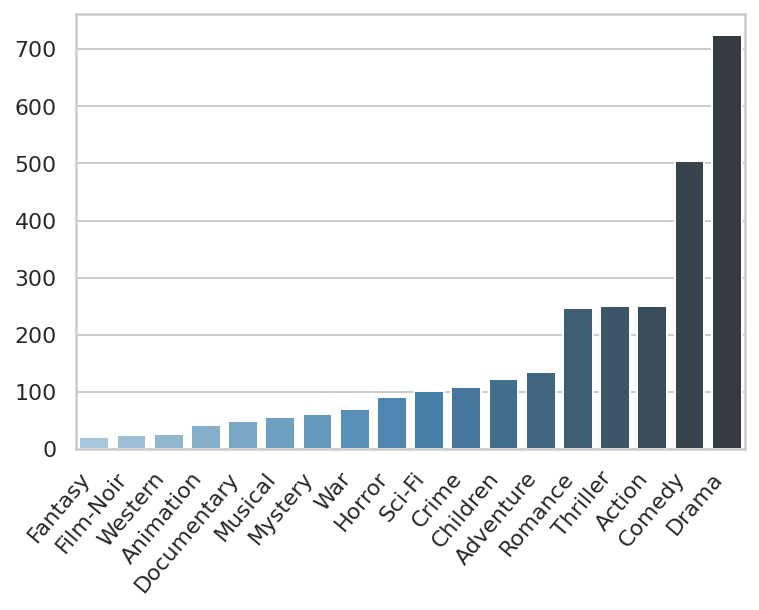

In [ ]:
genre_count = df_items[genre_cols].sum().sort_values()
sns.barplot(x=genre_count.index, y=genre_count.values,
            label="Total", palette="Blues_d")
plt.xticks(rotation=50, ha='right')
plt.show()

**PREGUNTA 1:** Explique cómo funciona **most popular** y **average rating**. 
¿Qué **problemas** podría encontrar al utilizar cada uno de ellos?.

**RESPUESTA**: **most popular** sortea los items de acuerdo a la cantidad/valor
de rating que estos poseen y recomienda una lista con los `n` items más bien valorados. Por otra parte, **Average Rating** determina los `n` rating más valorados **en promedio**.

Los problemas de **most popular** dicen relación con la inanición por falta de
rating de los items nuevos (estos son casi olvidados). Así mismo, **Average Rating** tiene problemas con el promedio calculado en cuanto determinado valor se podría obtener con 1 rating como también con una cantidad arbitraria de ratings, sesgando la recomendación.

## Most popular

In [ ]:
# Definicion de objeto "most popular"
most_popular = pyreclab.MostPopular(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# en teoria no es "entrenar" , objeto "most_popular" solo registra los items más
# populares en el set de entrenamiento  
most_popular.train()

Calculamos **métricas de ranking** $(nDCG@10$ y $MAP)$ para conocer el rendimiento de nuestro recomendador en el set de test. 

1. **DCG@10**: normalized discounted cummulative gain @ 10 

$$
\begin{align}
  DCG  &= \sum{ \frac{2^{rel} -1 }{log_2(i+1)}} \\
  nDCG &= \frac{DCG}{IDCG}
\end{align}
$$
donde,

* $IDCG: $ ideal DCG donde todos los relevantes están en las primeras posiciones.
* $nDCG@10$ es la métrica nDCG para los primeros 10 items recomendados. 

2. MAP: Mean Average Precision 

$$
\begin{align}
  AveP &= \frac{\sum{P(k) * rel(k)}}{total items relevantes} \\
  MAP  &= \sum{\frac{AveP(u)}{U}}
\end{align}
$$

donde,

* $P(k):$ precision en posicion k (P@10 or "Precision at 10" corresponde al numero de items relevantes en las primeras 10 posiciones)  
* $rel(k): $ 0 si el item no es relevante o 1 si es relevante.
* **TIP:** relevante por ejemplo es si es que el usuario le dió más de 3 estrellas de rating a un item.

**Ejemplo**

1. Sistema me **recomendó** estas 10 películas: 
```python
[13, 15, 35, 28, 3, 1, 100, 122]
```

2. El usuario en realidad **prefirió** estas películas:
```python
[13, 90, 12, 2, 3, 384, 219, 12938]
```

3. Construimos lista asignando un 1 si es relevante o 0 si no:
```python
[1, 0, 0, 0, 1, 0, 0, 0]
```

Sobre esta lista calculamos las métricas **nDCG@K** y **MAP** (serán vistas en más detalle en clases). 











In [ ]:
# Testing de recomendaciones sobre los primeros 10 items 
top_n = 10

recommendList, maprec, ndcg = most_popular.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.2889129174597905
NDCG@10: 0.1598011823409535


In [ ]:
# Calcular las recomendaciones para un usuario en particular (id = 2)
user_id1 = 2
user_id2 = 3
ranking1 = [int(r) for r in most_popular.recommend(str(user_id1), top_n, includeRated=False)] # False to consider only user-rated items, True to consider all rated items
ranking2 = [int(r) for r in most_popular.recommend(str(user_id2), top_n, includeRated=False)]
print(f'Recommendation for user {user_id1}: {ranking1}')
print(f'Recommendation for user {user_id2}: {ranking2}')

Recommendation for user 2: [50, 100, 258, 181, 294, 286, 288, 1, 300, 174]
Recommendation for user 3: [50, 100, 258, 181, 294, 286, 288, 1, 121, 300]


Notamos entonces en la recomendación que esta difiera para diferentes usarios puesto que toma en cuenta los items rateados por el usuario dado. Por otra parte, a continuación se muestra como se pierde todo grado de personalización en la recomendación al considerar **todos los items rateados**.

In [ ]:
# Notemos que sucede si consideramos TODOS los items rateados
ranking1 = [int(r) for r in most_popular.recommend(str(user_id1), top_n,
                                                  includeRated=True)] 
ranking2 = [int(r) for r in most_popular.recommend(str(user_id2), top_n,
                                                  includeRated=True)]
print(f'Recommendation for user {user_id1}: {ranking1}')
print(f'Recommendation for user {user_id2}: {ranking2}')

Recommendation for user 2: [50, 100, 258, 181, 294, 286, 288, 1, 121, 300]
Recommendation for user 3: [50, 100, 258, 181, 294, 286, 288, 1, 121, 300]


In [ ]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking1]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
121,Independence Day (ID4) (1996),03-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Independence%...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0



**PREGUNTA 2**: Cambiar el id de usuario, qué se puede observar de las recomendaciones?

**RESPUESTA:** Estas difieren en los últimos dos elementos lo cual se debe al
parámetro `includeRated` de `mostpopular.recommend()`. Sucede que `includeRated` determina si se usan o no **todos los items** rateados, en este sentido, al correrlo con `includeRated=False` estamos considerando solo los items rateados por el usuario dado, mientras que en `includeRated=True` consideramos todos los items rateados por la comunidad. Esto se puede ver en las celdas de arriba, notemos que para `includeRated=True` se pierde todo grado de personalización en la recomendación.

## Item average rating 

In [ ]:
# Definicion de objeto "item average rating"
item_avg = pyreclab.ItemAvg(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# en teoria no es "entrenar" , objeto "item_average" solo registra los items con mayor rating promedio en el set de entrenamiento  
item_avg.train()

In [ ]:
# Testing de recomendaciones sobre los primeros 10 items 
top_n = 17

recommendList, maprec, ndcg = item_avg.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.010562299267256242
NDCG@17: 0.006182601575740816


In [ ]:
# Calcular las recomendaciones para un usuario en particular (id = 2)
user_id = 2
user_id = 3

ranking1 = [int(r) for r in item_avg.recommend(str(user_id1), top_n, includeRated=False)] 
ranking2 = [int(r) for r in item_avg.recommend(str(user_id2), top_n, includeRated=False)]
print(f'Recommendation for user {user_id1}: {ranking1}')
print(f'Recommendation for user {user_id2}: {ranking2}')

Recommendation for user 2: [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293, 1201, 1189, 1122, 814, 1449, 114, 318]
Recommendation for user 3: [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293, 1201, 1189, 1122, 814, 1449, 114, 408]


In [ ]:
ranking1 = [int(r) for r in item_avg.recommend(str(user_id1), top_n, includeRated=True)] 
ranking2 = [int(r) for r in item_avg.recommend(str(user_id2), top_n, includeRated=True)]
print(f'Recommendation for user {user_id1}: {ranking1}')
print(f'Recommendation for user {user_id2}: {ranking2}')

Recommendation for user 2: [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293, 1201, 1189, 1122, 814, 1449, 114, 318]
Recommendation for user 3: [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293, 1201, 1189, 1122, 814, 1449, 114, 318]


**OBS.** Notemos como al igual que en el caso de **most popular**, perdemos todo grado de personalización al usar `includeRated=True`. Por otra parte, se puede justificar el decremento en las métricas usadas con el fuerte desbalanceo (alto _skewness_) de la database usada (ver gráfico de distribución de películas por género más arriba).

In [ ]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking1]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1064,Crossfire (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Crossfire%20(...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1472,"Visitors, The (Visiteurs, Les) (1993)",19-Jul-1996,NaN,"http://us.imdb.com/M/title-exact?Visiteurs,%20...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1450,Golden Earrings (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Aiqing%20Wans...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
